In [56]:
# Imports
import os
import xml.etree.ElementTree as ET
import glob
from PIL import Image
from pathlib import Path
from skimage import io
from skimage.transform import resize

from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
from torchvision import models, transforms
import timm

import numpy as np
import pandas as pd

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import BisectingKMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import fowlkes_mallows_score, silhouette_score

In [57]:
# 1. Feature Extraction

# Resize each cropped image to a 224x224

# Get x and y coordinates from annotations for bounding box information
def get_bounding_boxes(annot):
    xml = annot
    tree = ET.parse(xml)
    root = tree.getroot()
    objects = root.findall('object')
    bbox = []
    for o in objects:
        bndbox = o.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        bbox.append((xmin, ymin, xmax, ymax))
    return bbox
    
# Get image path from annotation path
def get_image(annot):
    img_path = './images/'
    file = annot.split('\\')
    img_filename = img_path + file[-2] + '\\' + file[-1] + '.jpg' 
    return img_filename

# Cropping and resizing images using bounding box info
def crop_and_resize(images, annotations):
    for i in range(len(images)):
        bbox = get_bounding_boxes(annotations[i])
        dog = get_image(annotations[i])
        im = Image.open(dog)
        for j in range(len(bbox)):
            im2 = im.crop(bbox[j])
            im2 = im2.resize((224,224), Image.Resampling.LANCZOS)
            new_path = dog.replace('./images/', './Processed_Data/')
            new_path = new_path.replace('.jpg', '-' + str(j) + '.jpg')
            im2 = im2.convert('RGB')
            head, tail = os.path.split(new_path)
            Path(head).mkdir(parents=True, exist_ok=True)
            im2.save(new_path)

# File paths
image_files = glob.glob('./images/*/*')
annotations = glob.glob('./annotations/*/*')

# Call crop_and_resize to get processed images
crop_and_resize(image_files, annotations)


In [58]:
# processed data path
processed = glob.glob('./Processed_Data/*/*')

In [72]:
# Normalize the data
    # Sources: https://kozodoi.me/blog/20210527/extracting-features
class ImageData(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(image=np.array(img))["image"]
        return img


def get_labels(image_files):
    labels = []
    for image_file in image_files:
        breed = os.path.basename(os.path.dirname(image_file))
        labels.append(breed)
    return labels

labels = get_labels(image_files)

unique_labels = np.unique(labels)
label_map = {label: i for i, label in enumerate(unique_labels)}
encoded_labels = np.array([label_map[label] for label in labels])

# Transforming data
transform = A.Compose([A.Resize(height=224,width=224),
                       A.Normalize(),
                       ToTensorV2()])
dataset = ImageData(image_paths=processed, transform=transform)
data_loader = DataLoader(dataset, batch_size=32, num_workers=0)

In [60]:
# Extract features for each image of layer resnet18
    # Sources: https://kozodoi.me/blog/20210527/extracting-features

# build the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model(model_name="resnet18", pretrained=True)
model.fc = nn.Linear(512, 2)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [5]:
# Hook function - from: https://kozodoi.me/blog/20210527/extracting-features
def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook
model.global_pool.register_forward_hook(get_features("feats"))


In [6]:
# Extracting features - from: https://kozodoi.me/blog/20210527/extracting-features
# placeholders
PREDS = []
FEATS = []

# placeholder for batch features
features = {}

# loop through batches
for idx, inputs in enumerate(data_loader):
    # move to device
    inputs = inputs.to(device)

    # forward pass [with feature extraction]
    preds = model(inputs)

    # add feats and preds to lists
    PREDS.append(preds.detach().cpu().numpy())
    FEATS.append(features["feats"].cpu().numpy())

    # early stop
    if idx == 9:
        break

# Inspect features
PREDS = np.concatenate(PREDS)
FEATS = np.concatenate(FEATS)

print("- preds shape:", PREDS.shape)
print("- feats shape:", FEATS.shape)

- preds shape: (320, 2)
- feats shape: (320, 512)


In [7]:
# 2) Dimensionality Reduction
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(FEATS)

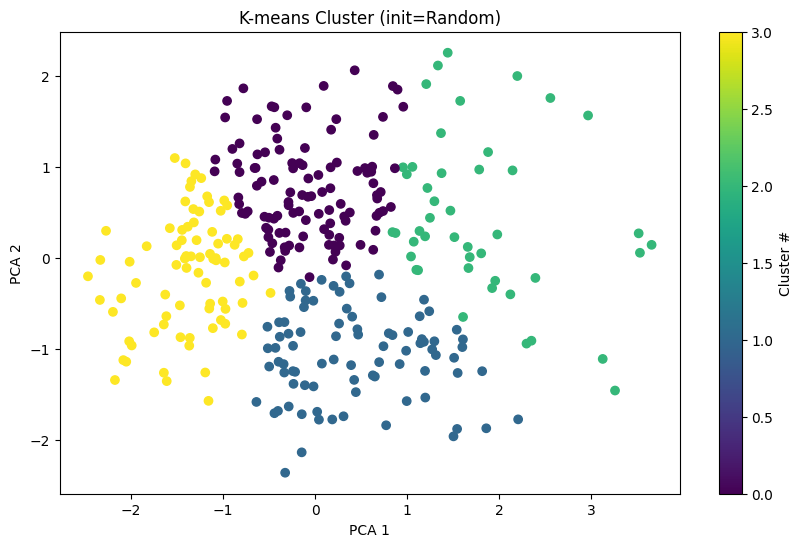

In [14]:
# 3) Clustering Algorithm

# K-mean cluster K=4
    # a. K-means with init=Random
k_random = KMeans(n_clusters=4, init='random', random_state=42)
k_random_cluster = k_random.fit_predict(reduced_data)

plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=k_random_cluster)
plt.title("K-means Cluster (init=Random)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Cluster #")
plt.show()

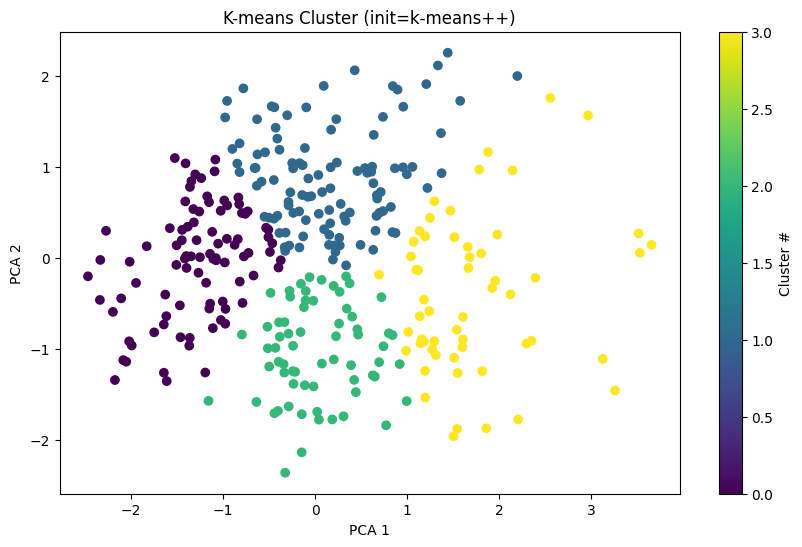

In [15]:
    # b. K-means with init=k-means++
k_plus = KMeans(n_clusters=4, init='k-means++', random_state=42)
k_plus_cluster = k_plus.fit_predict(reduced_data)

plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=k_plus_cluster)
plt.title("K-means Cluster (init=k-means++)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Cluster #")
plt.show()

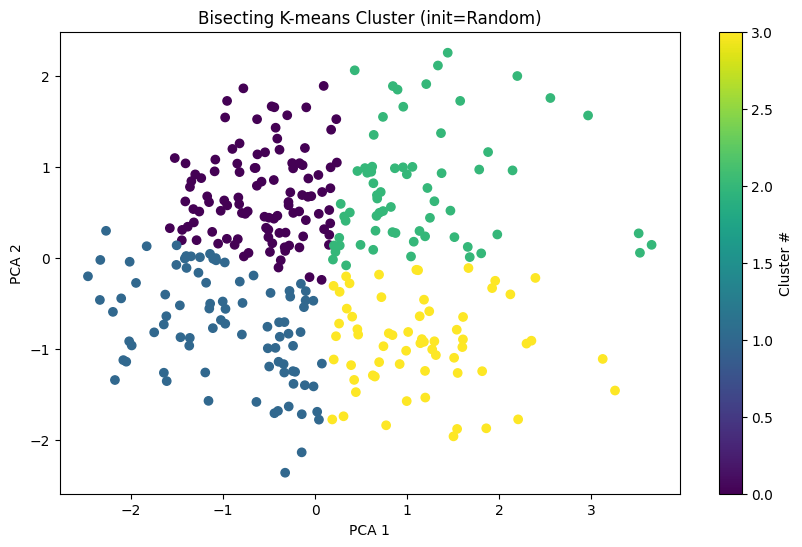

In [16]:
    # c. Bisecting K-means with init=random
bisect_k = BisectingKMeans(n_clusters=4, init='random', random_state=42)
bisect_k_cluster = bisect_k.fit_predict(reduced_data)

plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=bisect_k_cluster)
plt.title("Bisecting K-means Cluster (init=Random)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Cluster #")
plt.show()

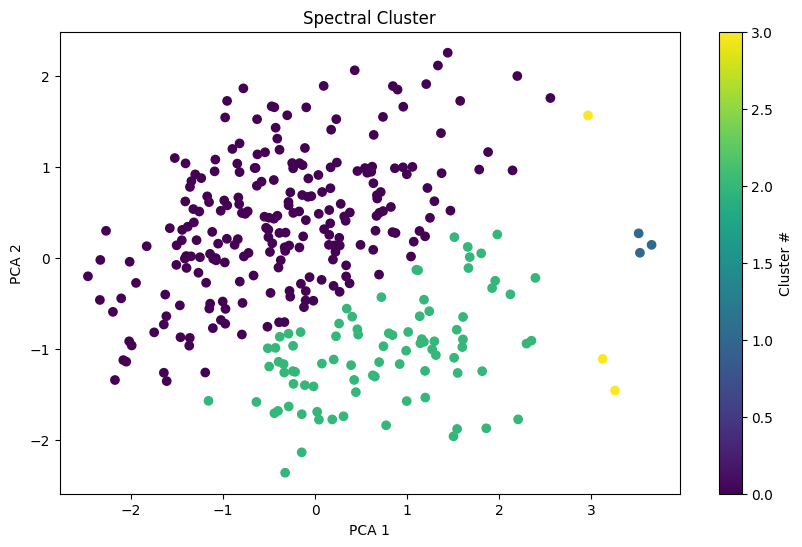

In [17]:
    # d. Spectral Clustering
spectral = SpectralClustering(n_clusters=4, random_state=42)
spectral_cluster = spectral.fit_predict(reduced_data)

plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=spectral_cluster)
plt.title("Spectral Cluster")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Cluster #")
plt.show()

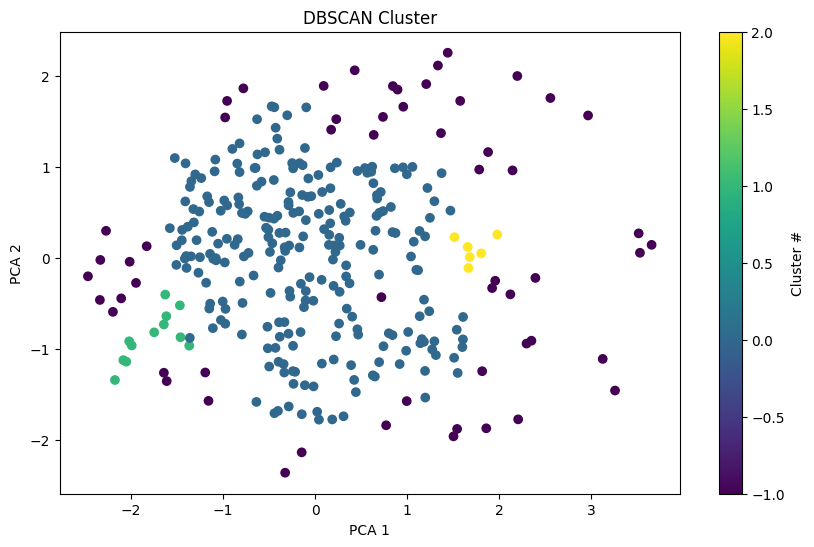

In [45]:
# DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=5)
dbscan_cluster = dbscan.fit_predict(reduced_data)

plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=dbscan_cluster)
plt.title("DBSCAN Cluster")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Cluster #")
plt.show()

# What eps and min_samples values did you use to get 4 clusters?
    # eps=0.3 and min_samples=5 to get 4 clusters

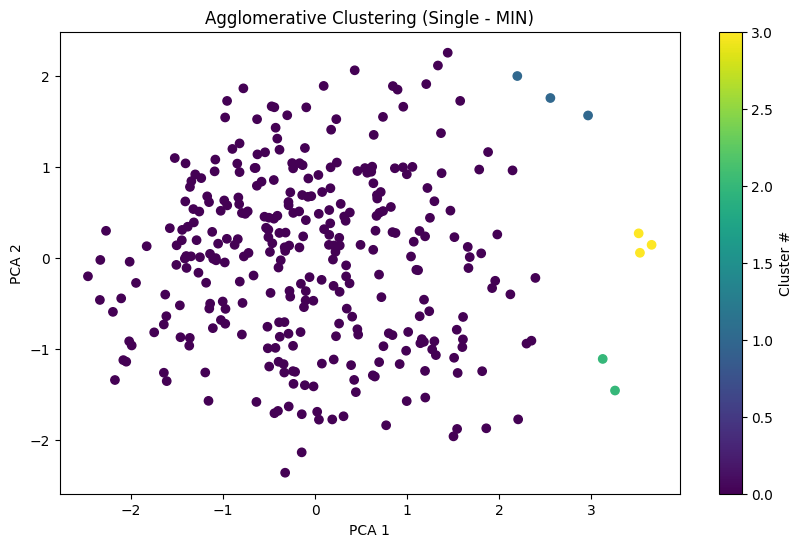

In [48]:
# Agglomerative Clustering

    # a. Single link (MIN)
agg_min = AgglomerativeClustering(n_clusters=4, linkage='single')
agg_min_cluster = agg_min.fit_predict(reduced_data)

plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=agg_min_cluster)
plt.title("Agglomerative Clustering (Single - MIN)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Cluster #")
plt.show()

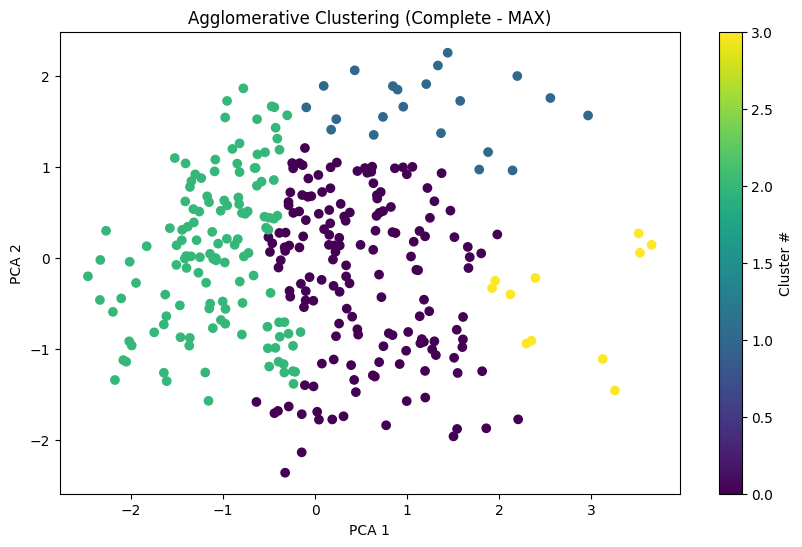

In [49]:
    # b. Complete link (MAX)
agg_max = AgglomerativeClustering(n_clusters=4, linkage='complete')
agg_max_cluster = agg_max.fit_predict(reduced_data)

plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=agg_max_cluster)
plt.title("Agglomerative Clustering (Complete - MAX)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Cluster #")
plt.show()

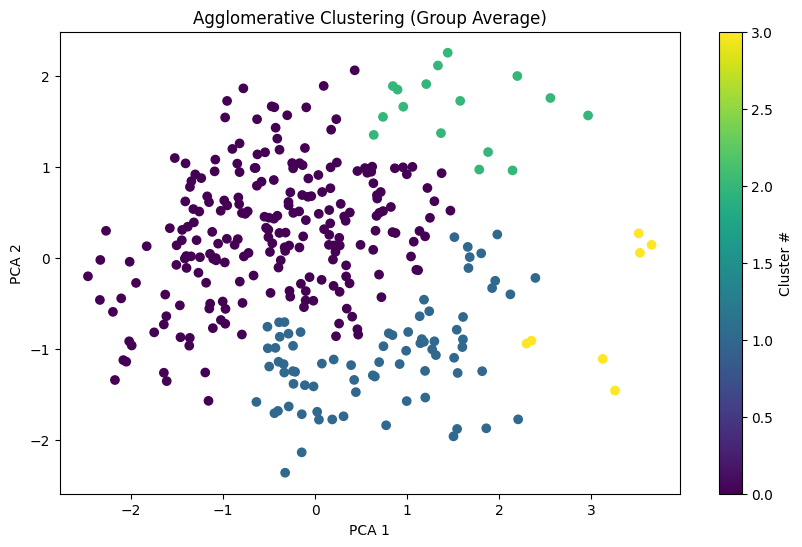

In [50]:
    # c. Group Average
agg_avg = AgglomerativeClustering(n_clusters=4, linkage='average')
agg_avg_cluster = agg_avg.fit_predict(reduced_data)

plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=agg_avg_cluster)
plt.title("Agglomerative Clustering (Group Average)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Cluster #")
plt.show()

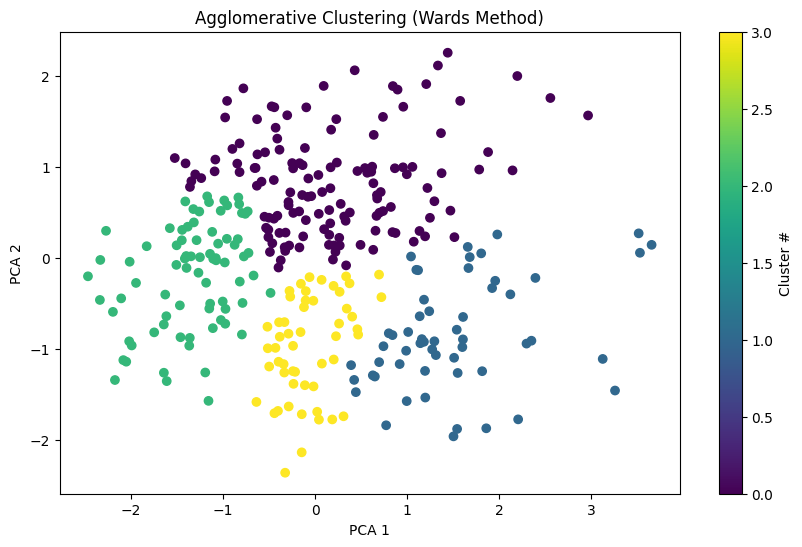

In [51]:
    # d. Wards method
agg_ward = AgglomerativeClustering(n_clusters=4, linkage='ward')
agg_ward_cluster = agg_ward.fit_predict(reduced_data)

plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=agg_ward_cluster)
plt.title("Agglomerative Clustering (Wards Method)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Cluster #")
plt.show()

In [76]:
# 4) Clustering Evaluations

    # a. perform clusteing eval using Fowlkes-Mallows for each method in #3
k_random_fms = fowlkes_mallows_score(encoded_labels, k_random_cluster)
k_plus_fms = fowlkes_mallows_score(encoded_labels, k_plus_cluster)
bisect_k_fms = fowlkes_mallows_score(encoded_labels,bisect_k_cluster)
spectral_fms = fowlkes_mallows_score(encoded_labels, spectral_cluster)
dbscan_fms = fowlkes_mallows_score(encoded_labels, dbscan_cluster)
agg_min_fms = fowlkes_mallows_score(encoded_labels, agg_min_cluster)
agg_max_fms = fowlkes_mallows_score(encoded_labels, agg_max_cluster)
agg_avg_fms = fowlkes_mallows_score(encoded_labels, agg_avg_cluster)
agg_ward_fms = fowlkes_mallows_score(encoded_labels, agg_ward_cluster)

fms = {
    "K-Means init=Random": k_random_fms,
    "K-Means init=k-means++": k_plus_fms,
    "Bisecting K-Means": bisect_k_fms,
    "Spectral": spectral_fms,
    "DBSCAN": dbscan_fms,
    "Single (MIN)": agg_min_fms,
    "Complete (MAX)": agg_max_fms,
    "Group AVG": agg_avg_fms,
    "Wards Method": agg_ward_fms
}

ValueError: Found input variables with inconsistent numbers of samples: [654, 320]

In [78]:
    # Silhouette Coeefficient for each method
silhouette_scores = {
    "K-means init=random": silhouette_score(reduced_data, k_random_cluster),
    "K-means init=k-means++": silhouette_score(reduced_data, k_plus_cluster),
    "Bisecting K-means": silhouette_score(reduced_data, bisect_k_cluster),
    "Spectral": silhouette_score(reduced_data, spectral_cluster),
    "DBSCAN": silhouette_score(reduced_data, dbscan_cluster),
    "Single (MIN)": silhouette_score(reduced_data, agg_min_cluster),
    "Complete (MAX)": silhouette_score(reduced_data, agg_max_cluster),
    "Group AVG": silhouette_score(reduced_data, agg_avg_cluster),
    "Wards method": silhouette_score(reduced_data, agg_ward_cluster)
}

In [ ]:
    # c. Rank Fowlkes-Mallows

In [88]:
    # d. Rank Silhouette Coefficient
ranked_sil = sorted(silhouette_scores.items(), key=lambda x: x[1])
print("Silhouette Score Rankings:")
for method, score in ranked_sil:
        print(f"{method}: {score:.3f}")

Silhouette Score Rankings:
DBSCAN: -0.028
Complete (MAX): 0.244
Group AVG: 0.283
Spectral: 0.319
Wards method: 0.320
Bisecting K-means: 0.328
K-means init=k-means++: 0.352
K-means init=random: 0.356
Single (MIN): 0.371
